# Майнор по Анализу Данных, Группа ИАД-4
## 21/09/2017 Методы Оптимизации

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

try:
    from ipywidgets import interact, IntSlider, fixed, FloatSlider
except ImportError:
    print(u'Так надо')

# Но в начале...
Еще пару слов про SVM

SVM позволяет встраивать собственные ядра! И это вам пригодится в домашке.

(3.2999999999999998, 8.8800000000000061, 1.0, 5.3800000000000043)

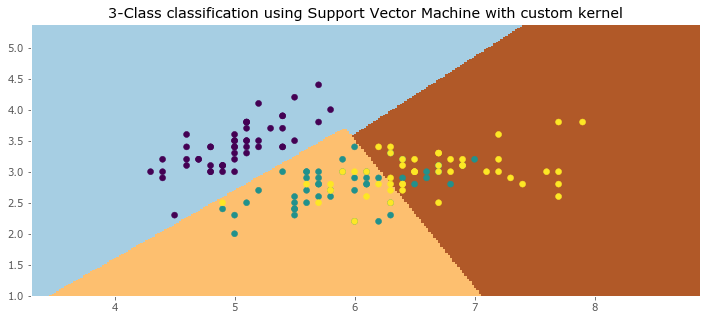

In [2]:
# Не помню, откуда взял этот код...

from sklearn import svm, datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = iris.target


def my_kernel(U, V):
    """
    We create a custom kernel:

                 (2  0)
    k(U, V) = U  (    ) V.T
                 (0  1)
    """
    M = np.array([[2, 0], [0, 1.0]])
    return np.dot(np.dot(U, M), V.T)


h = .02  # step size in the mesh

# we create an instance of SVM and fit out data.
clf = svm.SVC(kernel=my_kernel)
clf.fit(X, y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title('3-Class classification using Support Vector Machine with custom'
          ' kernel')
plt.axis('tight')

# Методы оптимизации

Как было показано на лекции, большинство методов машинного обучения сводятся к поиску параметров, которые минимизируют ошибку на тренировочной выборке:
$$
\min_{\beta} L(\beta; D)
$$
Здесь:
* $D$ — размеченная обучающая выборка, $\{x^{(i)}, y^{(i)}\}_{i=1}^N$
* $L$ — функция потерь
* $\beta$ — настраиваемые веса алгоритма

В более общем виде задачу можно записать так:
$$
\min_{x} f(x)
$$
Здесь:
* $x$ — вектор значений
* $f$ — функция, принимающая вектор в качестве аргумента и выдающая числовое значение.

На семинаре рассмотрим подробнее методы минимизации функции, которые рассматривались на лекции.

# Градиентный спуск

Для оптимизации возьмем простую функцию $f(x) = x^3 - 2x^2 + 2$

(0, 3)

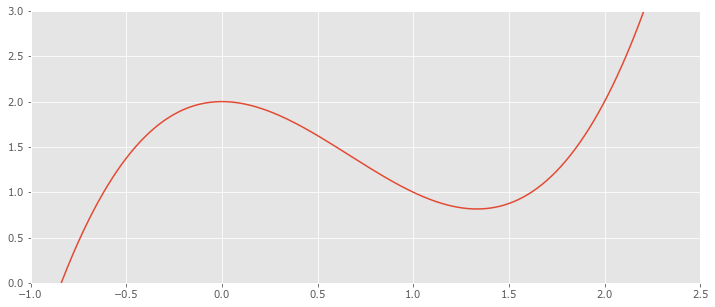

In [3]:
f = lambda x: x ** 3 - 2*x ** 2 + 2
df = lambda x: 3 * x ** 2 - 4 * x # производная
x = np.linspace(-1, 2.5, 1000)
plt.plot(x, f(x))
plt.xlim([-1, 2.5])
plt.ylim([0, 3])

И определим функцию, которая будет оптимизировать функцию $f(x)$ градиентным спуском с заданным постоянным шагом (он же learning rate, темп обучения).

In [4]:
def optimize_and_plot_steps(learning_rate, x_new=2, compute_learning_rate=None):
    x_old = 0
    # x_new — точка старта
    eps = 0.0001
    x_list, y_list = [x_new], [f(x_new)] # инициализируем список координат и значений функций при итерации
    
    # спускаемся, пока разница между координатами не достигла требуемой точности
    i = 0
    while abs(x_new - x_old) > eps: 
        x_old = x_new
        # считаем направление спуска
        direction = -df(x_old)
        # обновляем значение темпа обучения, если нам задана функция для этого
        if compute_learning_rate is not None:
            learning_rate = compute_learning_rate(i, learning_rate)
        # делаем шаг
        x_new = x_old + learning_rate * direction
        # запоминаем очередной шаг минимизации
        x_list.append(x_new)
        y_list.append(f(x_new))
        i += 1
        
    print "Найденный локальный минимум:", x_new
    print "Количество шагов:", len(x_list)
    
    plt.figure(figsize=[10,3])
    
    plt.subplot(1,2,1)
    plt.scatter(x_list, y_list, c="r")
    plt.plot(x_list, y_list, c="r")
    plt.plot(x, f(x), c="b")
    plt.xlim([-1,2.5])
    plt.ylim([0,3])
    plt.title("Descent trajectory")

    plt.subplot(1,2,2)
    plt.scatter(x_list,y_list,c="r")
    plt.plot(x_list,y_list,c="r")
    plt.plot(x,f(x), c="b")
    plt.xlim([1.2,2.1])
    plt.ylim([0,3])
    plt.title("Descent trajectory (zoomed in)")

Попробуем оптимизацию с шагом 0.1

Найденный локальный минимум: 1.33342535085
Количество шагов: 17


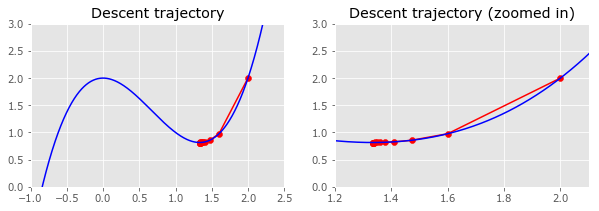

In [5]:
optimize_and_plot_steps(0.1)

Возьмем шаг побольше.

Найденный локальный минимум: 1.33330202239
Количество шагов: 15


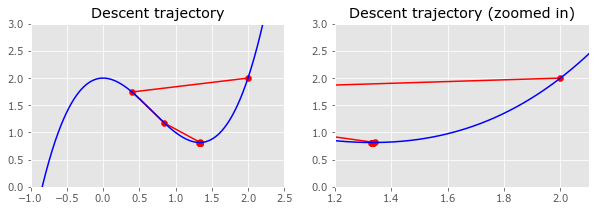

In [8]:
optimize_and_plot_steps(0.4)

Что, если взять 0.5?

Найденный локальный минимум: 0.0
Количество шагов: 3


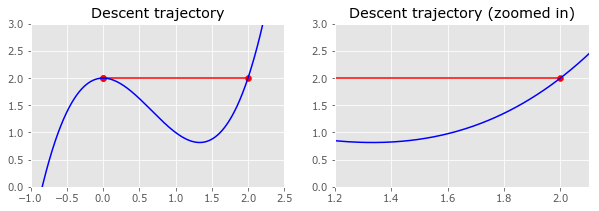

In [7]:
optimize_and_plot_steps(0.5)

Застопорились в нуле, т.к. нашли точный локальный максимум. В нем производная равна нулю и мы никуда не можем сдвинуться. А если взять 0.49?

Найденный локальный минимум: 1.33338127064
Количество шагов: 188


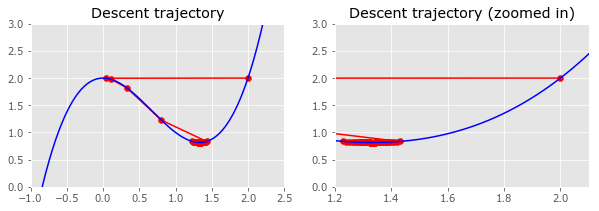

In [10]:
optimize_and_plot_steps(0.49)

Что, если взять 0.51?

In [11]:
optimize_and_plot_steps(0.51)

OverflowError: (34, 'Result too large')

Мы улетели далеко влево. Это можно понять, распечатав значения x_new.

Теперь возьмём маленький шаг. Например, 0.05.

Найденный локальный минимум: 1.33372973128
Количество шагов: 32


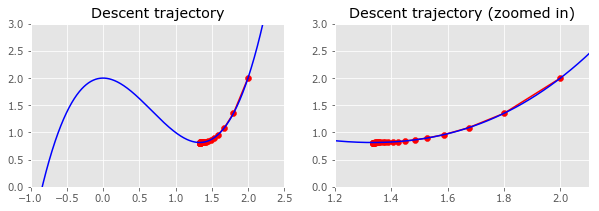

In [12]:
optimize_and_plot_steps(0.05)

0.01?

Найденный локальный минимум: 1.3356881625
Количество шагов: 129


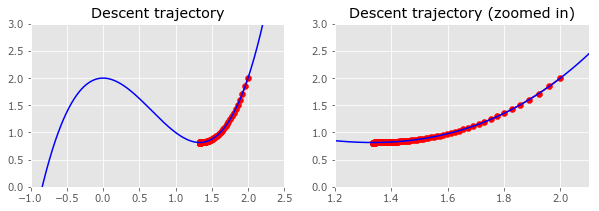

In [13]:
optimize_and_plot_steps(0.01)

Чем меньше шаг, тем медленнее мы идём к минимум (и можем вдобавок застрять по пути). Чем больше темп обучения, тем большие расстояния мы перепрыгиваем (и имеем гипотетическую возможность найти минимум получше). Хорошая стратегия — начинать с достаточно большого шага (чтобы хорошо попутешествовать по функции), а потом постепенно его уменьшать, чтобы стабилизировать процесс обучения в каком-то локальном минимуме.

Теперь будем изменять шаг динамически:
$lr(i + 1) = lr(i) * 0.9$.

In [14]:
def compute_learning_rate(i, prev_lr):
    return prev_lr * 0.9

Найденный локальный минимум: 1.33333760095
Количество шагов: 7


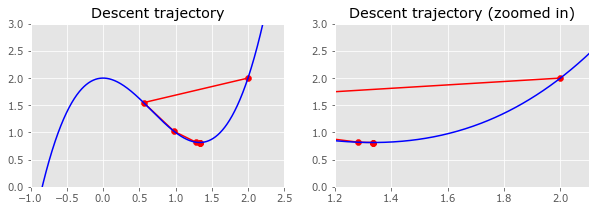

In [15]:
optimize_and_plot_steps(0.4, compute_learning_rate=compute_learning_rate)

Если сравнивать с постоянным темпом обучения, то мы нашли минимум в 2 раза быстрее.

Найденный локальный минимум: 1.33330202239
Количество шагов: 15


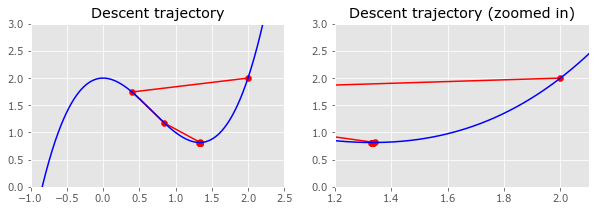

In [16]:
optimize_and_plot_steps(0.4)

Это, конечно, искуственный пример, но такая же идея используются для обучения алгоритмов машинного обучения с миллионами параметров, функции потерь которых имеют очень сложную структуру и не поддаются визуализации.

In [17]:
def gradient_descent(X, y, iters, alpha):
    costs = []
    n = y.shape[0] 
    Beta = np.random.rand(2)
    history = [Beta] 
    preds = []
    for i in xrange(iters):
        y_hat = X.dot(Beta)
        error = y_hat - y 
        cost = np.mean(error ** 2) / 2
        
        if i % 100 == 0: 
            preds.append(y_hat)
            history.append(Beta)
            costs.append(cost)

        gradient = X.T.dot(error)
        Beta = Beta - alpha / n * gradient  # update
        
        
    return history, costs, preds, Beta

In [18]:
res = gradient_descent(X, y, 1000, 0.05)

# Градиентный спуск для линейной регрессии

## Описание задачи линейной регрессии

Напомним суть метода градиентого спуска в контексте задачи линейной регрессии.

Дано описание $n$ объектов по $m$ признакам. Обычно оно выражается в виде матрицы размера $n \times m$: $X = [x^{(i)}_j]^{i=1\dots n}_{j=1\dots m} $.<br\> ($x^{(i)}_j$ означает $j$-ый признак $i$-го объекта) <br\>
Дана зависимая переменная, которая тоже имеет отношение к этим объекам: $y$ - вектор длины $n$.

Наша задача, выявить **линейную** зависимость между признаками в $X$ и значениями в $y$:
$$\hat{y} = X\beta \quad \Leftrightarrow \quad \hat{y}^{(i)} = \beta_0 + \beta_1x^{(i)}_1 + \dots$$

И сделать это так, чтобы квадрат суммы ошибок наших оценок был минимален:
$$ L(\beta) = \frac{1}{2n}(\hat{y} - y)^{\top}(\hat{y} - y) = \frac{1}{2n}(X\beta - y)^{\top}(X\beta - y) \rightarrow \min$$ $$ \Updownarrow $$  $$ L(\beta_0,\beta_1,\dots) = \frac{1}{2n}\sum^{n}_{i=1}(\hat{y}^{(i)} - y^{(i)})^2 = \frac{1}{2n}\sum^{n}_{i=1}(\beta_0 + \beta_1x^{(i)}_1 + \dots - y^{(i)})^2  \rightarrow \min $$

Значение в $X$ и $y$ нам даны. Нам неизвестны только значения коэффициентов $\beta$.<br\> Соответственно, нужно найти такие значения $\beta$, что функция $L(\beta) \rightarrow \min.$

## Описание метода градиентного спуска для регрессии

Пусть нам известнен 1 признак объекта и мы включаем свободный член у ровнение регрессии.

Посчитаем, чему равен градиент функции потерь $L(\beta_0, \beta_1):$
$$ \frac{\partial L}{\partial \beta_0} = \frac{1}{n}\sum^{n}_{i=1}(\beta_0 + \beta_1x^{(i)}_1 - y^{(i)})$$
$$ \frac{\partial L}{\partial \beta_1} = \frac{1}{n}\sum^{n}_{i=1}(\beta_0 + \beta_1x^{(i)}_1 - y^{(i)})x_1^{(i)}$$

Иногда проще это записать в виде матриц:
$$ \nabla_\beta L(\beta) = X^\top(X\beta - y)$$


Метод градиентного спуска заключается в итеративном и **одновременном(!!!)** обновлении значений $\beta$ в направлении, противоположному градиенту:
$$ \beta := \beta - \alpha\nabla_\beta L(\beta)$$

## Пошаговое описание программной реализации

Для начала нам понадобятся данные. 

Используем те же данные про грузовики, что и были даны на втором семинаре. Нам дано два столбца значений — количество жителей в городе и доход грузовика с уличной едой в этом городе.

Будем строить модель, описывающую зависимость дохода от размера населения.

In [20]:
!ls

data.zip                               saddle_point_evaluation_optimizers.gif
food_trucks.txt                        space_ga.txt
minor-seminar-opt.ipynb.ipynb


In [21]:
!head ./food_trucks.txt

6.1101,17.592
5.5277,9.1302
8.5186,13.662
7.0032,11.854
5.8598,6.8233
8.3829,11.886
7.4764,4.3483
8.5781,12
6.4862,6.5987
5.0546,3.8166


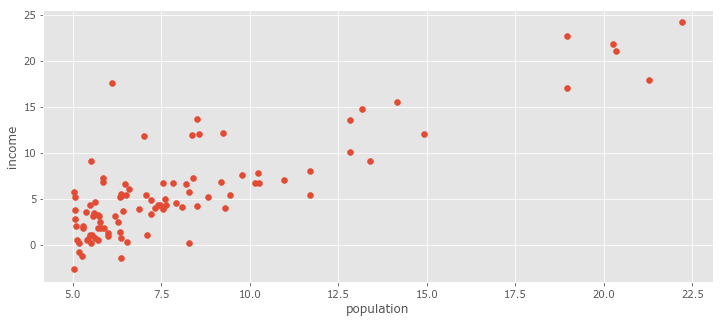

In [42]:
filepath = os.path.join('food_trucks.txt')
data = np.loadtxt(filepath, delimiter=',')
plt.scatter(data[:,0], data[:, 1])
plt.xlabel('population')
plt.ylabel('income')

In [24]:
data

array([[  6.1101 ,  17.592  ],
       [  5.5277 ,   9.1302 ],
       [  8.5186 ,  13.662  ],
       [  7.0032 ,  11.854  ],
       [  5.8598 ,   6.8233 ],
       [  8.3829 ,  11.886  ],
       [  7.4764 ,   4.3483 ],
       [  8.5781 ,  12.     ],
       [  6.4862 ,   6.5987 ],
       [  5.0546 ,   3.8166 ],
       [  5.7107 ,   3.2522 ],
       [ 14.164  ,  15.505  ],
       [  5.734  ,   3.1551 ],
       [  8.4084 ,   7.2258 ],
       [  5.6407 ,   0.71618],
       [  5.3794 ,   3.5129 ],
       [  6.3654 ,   5.3048 ],
       [  5.1301 ,   0.56077],
       [  6.4296 ,   3.6518 ],
       [  7.0708 ,   5.3893 ],
       [  6.1891 ,   3.1386 ],
       [ 20.27   ,  21.767  ],
       [  5.4901 ,   4.263  ],
       [  6.3261 ,   5.1875 ],
       [  5.5649 ,   3.0825 ],
       [ 18.945  ,  22.638  ],
       [ 12.828  ,  13.501  ],
       [ 10.957  ,   7.0467 ],
       [ 13.176  ,  14.692  ],
       [ 22.203  ,  24.147  ],
       [  5.2524 ,  -1.22   ],
       [  6.5894 ,   5.9966 ],
       [

In [59]:
# Тогда X - это будет матрица размера ( 97x2 ), a y - вектор-столбец

# Отнормируем данные
data[:, 0] = (data[:, 0] - data[:, 0].mean())/data[:, 0].std()
X = np.c_[data[:, 0], np.ones((data.shape[0], 1))]

y = data[:, 1]

In [60]:
X[:10]

array([[-0.53240565,  1.        ],
       [-0.68368294,  1.        ],
       [ 0.09319761,  1.        ],
       [-0.30042464,  1.        ],
       [-0.5974206 ,  1.        ],
       [ 0.0579498 ,  1.        ],
       [-0.17751184,  1.        ],
       [ 0.10865262,  1.        ],
       [-0.4347144 ,  1.        ],
       [-0.80656976,  1.        ]])

In [61]:
y[:10]

array([ 17.592 ,   9.1302,  13.662 ,  11.854 ,   6.8233,  11.886 ,
         4.3483,  12.    ,   6.5987,   3.8166])

Теперь научимся считать ошибку модели. Для этого нам нужны коэффициенты. 
Пока возьмем некоторые случайные значения

In [62]:
Beta = np.array([5,6])

In [63]:
Beta

array([5, 6])

Как было показано выше: 
$$ \hat{y}^{(i)} = \beta_0 + \beta_1x^{(i)}_1 + \dots \quad \Leftrightarrow \quad \hat{y} = X\beta \quad \Leftrightarrow \quad \texttt{y_hat = X.dot(Beta)} $$

In [64]:
y_hat = X.dot(Beta)

Соответственно, ошибка это $(X\beta - y)$, а функция потерь $ L(\beta) = \frac{1}{2n}(X\beta - y)^{\top}(X\beta - y) = \frac{1}{2n}\sum^{n}_{i=1}(\beta_0 + \beta_1x^{(i)}_1 + \dots - y^{(i)})^2 $

In [65]:
error = (X.dot(Beta) - y)

n = X.shape[0]
cost = np.sum(error ** 2) / (2 * n)

In [66]:
error[:10]

array([-14.25402826,  -6.54861469,  -7.19601193,  -7.35612318,
        -3.81040299,  -5.59625101,   0.76414079,  -5.45673688,
        -2.77227199,  -1.84944879])

In [67]:
cost

4.5727179013629575

Отлично, мы научились считать ошибку при заданных $\beta$. Теперь выразим градиент:

$$ \nabla_\beta L(\beta)= X^\top(X\beta - y) \quad \Leftrightarrow \quad  \texttt{grad = X.T.dot(error)} $$

In [68]:
grad = X.T.dot(error)

In [69]:
grad

array([ 39.47501006,  15.6039    ])

Теперь к шагам алгоритма:

* Задаем случайное начальное значение для $\beta$
* Пока не будет достигнуто правило останова:
    * Считаем ошибку и значение функции потерь
    * Считаем градиент
    * Обновляем коэффициенты

In [70]:
def gradient_descent(X, y, iters, alpha):
    n = y.shape[0] 
    Beta = np.random.rand(2)
    for i in xrange(iters):
        y_hat = X.dot(Beta)
        
        # считаем ошибку и значение функции потерь
        error = y_hat - y 
        cost = np.sum(error ** 2) / (2 * n)

        # считаем градиент
        gradient = X.T.dot(error)

        # обновляем коэффициенты
        Beta = Beta - alpha / n * gradient  # update
    return Beta

In [71]:
Beta = gradient_descent(X, y, 1000, 0.05)

In [72]:
Beta

array([ 4.59304113,  5.83913505])

Изобразим функцию потерь

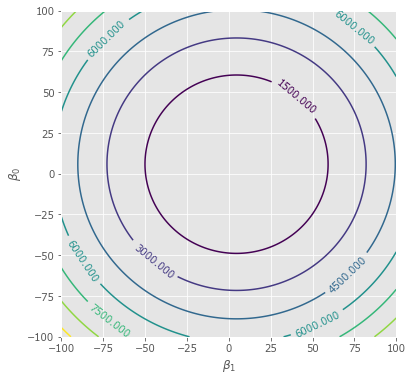

In [73]:
# Возьмем значения для коэффициентов на интервале от 0 до 10
beta0, beta1 = np.meshgrid(np.linspace(-100, 100, 1000), np.linspace(-100, 100, 1000))
BetaArr = np.r_[beta0.reshape(1,-1), beta1.reshape(1,-1)]

# Посчитаем ошибку от всевозможных паросочетаний
y_hat = X.dot(BetaArr)
error = y_hat - y.reshape(-1,1)
cost = np.sum(error ** 2, 0) / (2 * n)
cost = cost.reshape(beta0.shape)

plt.figure(figsize=(6,6))
contour = plt.contour(beta0, beta1, cost)
plt.clabel(contour, inline=1, fontsize=10)
plt.xlabel('$\\beta_1$')
plt.ylabel('$\\beta_0$')

## Задание

* Добавьте правило останова, срабатывающее при слабом изменении функции потерь
* Измените функцию градиентного спуска так, чтобы темп обучения мог меняться динамически 
* Дополните функцию, чтобы она так же выводила значения коэффициентов и функции потерь на некоторых итерациях. Выведите "прогресс" спуска на график выше


In [116]:
def gradient_descent(X, y, iters, alpha, tol=0.001):
    n = y.shape[0] 
    Beta = np.array([50,50])
    cost_prev = 0
    delta = 100
    i = 0
    Betas = []
    
    while (delta > tol) & (i < iters):
        y_hat = X.dot(Beta)
        
        # считаем ошибку и значение функции потерь
        error = y_hat - y 
        cost = np.sum(error ** 2) / (2 * n)
        
        delta = abs(cost_prev - cost)
        cost_prev = cost

        # считаем градиент
        gradient = X.T.dot(error)

        # обновляем коэффициенты
        Beta = Beta - alpha / n * gradient  # update
        
        alpha *= 1.0
        
        if (i % 2) == 0:
            Betas.append(Beta)
        
        i+=1
    return Betas

In [117]:
Betas = gradient_descent(X, y, 1000, 0.05)

In [119]:
Betas = np.c_[Betas]

In [120]:
Betas

array([[ 47.72965206,  47.79195675],
       [ 43.52383249,  43.70155664],
       [ 39.72808033,  40.00997053],
       [ 36.30241401,  36.67831407],
       [ 33.21075016,  33.67149412],
       [ 30.42052353,  30.95783911],
       [ 27.90234399,  28.50876546],
       [ 25.62968696,  26.2984765 ],
       [ 23.578614  ,  24.30369071],
       [ 21.72752064,  22.50339653],
       [ 20.05690889,  20.87863104],
       [ 18.54918178,  19.41228018],
       [ 17.18845807,  18.08889853],
       [ 15.96040492,  16.89454659],
       [ 14.85208695,  15.81664396],
       [ 13.85182998,  14.84383685],
       [ 12.94909807,  13.96587842],
       [ 12.13438252,  13.17352094],
       [ 11.39910173,  12.45841832],
       [ 10.73551082,  11.8130382 ],
       [ 10.13662003,  11.23058264],
       [  9.59612109,  10.7049165 ],
       [  9.10832079,  10.23050281],
       [  8.66808103,   9.80234445],
       [  8.27076464,   9.41593154],
       [  7.91218659,   9.06719388],
       [  7.58856991,   8.75245814],
 

Изобразим функцию потерь

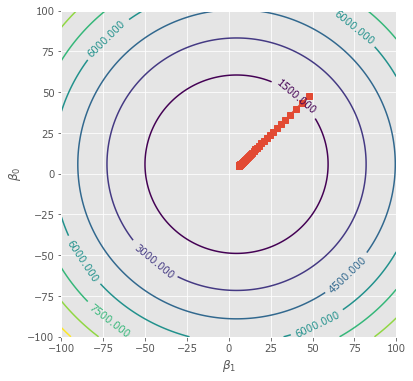

In [115]:
# Возьмем значения для коэффициентов на интервале от 0 до 10
beta0, beta1 = np.meshgrid(np.linspace(-100, 100, 1000), np.linspace(-100, 100, 1000))
BetaArr = np.r_[beta0.reshape(1,-1), beta1.reshape(1,-1)]

# Посчитаем ошибку от всевозможных паросочетаний
y_hat = X.dot(BetaArr)
error = y_hat - y.reshape(-1,1)
cost = np.sum(error ** 2, 0) / (2 * n)
cost = cost.reshape(beta0.shape)

plt.figure(figsize=(6,6))
contour = plt.contour(beta0, beta1, cost)
plt.clabel(contour, inline=1, fontsize=10)
plt.xlabel('$\\beta_1$')
plt.ylabel('$\\beta_0$')

plt.plot(Betas[:, 1], Betas[:, 0], 's-')

# Градиентный спуск с батч-оптимизацией

Теперь рассмотрим случай, когда данных в выборке много. 

В таких случаях используется стохастическая или батч-оптимизация. Первая состоит в том, что на каждом шаге итерации берется один объект, вторая — в том, что берется некоторое небольшое фиксированное количество объектов.

Загрузите данные из файла `space_ga.csv` и нормализуйте их. Мы будем предсказывать первый столбец по шести остальным. Эти данные получены с выборов в США в 1980 году. Подробнее о столбцах можно прочитать [тут](http://mldata.org/repository/data/viewslug/statlib-20050214-space_ga/1)

Как вы могли заметить, датасет больше предыдущего. На нём мы попробуем батч-оптимизацию.

## Задание
Измените функцию для градиентного спуска так, чтобы на вход они принимала дополнительный параметр — размер батча. Для простоты проверки рекомендуется изменять копию функции, реализованной выше, с измененным именем. Прокомментируйте результаты.

**Замечания**<br/>
* Объекты нужно сначала перемешать (`sklearn.utils.shuffle`), а затем разделить на батчи
* Учитите, что ошибка (и, соответственно, градиент) считается об объектам попавшим в батч, а значение функции потерь - по всем объектам.

# Другие изощренные модификации

#### Метод накопленного импульса

$$ v_t = \gamma v_{t-1} + \alpha\nabla_\beta L(\beta)$$
$$ \beta = \beta - v_t $$

#### Метод Нестерова

$$ v_t = \gamma v_{t-1} + \alpha\nabla_\beta L(\beta - \gamma v_{t-1})$$
$$ \beta = \beta - v_t $$

#### Адаптивный градиент

$g_t$ - производная по одному из параметров $\frac{\partial L}{\partial \beta_j}$

$$ G_t = G_t + g_t^2$$
$$ \beta_j = \beta_j - \frac{\alpha}{\sqrt{G_t + \epsilon}} g_t$$